## Joining Data Streams
### Step 1 : Initialize Spark Session 

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, expr

conf = SparkConf().setAppName("Spark Stream Join DEMO").setMaster("local[*]")
spark = SparkSession.builder.config(conf = conf).getOrCreate()

### Step 2 : Load Two Data Streams from Kafka

In [2]:
climate_stream = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", "Climate") \
  .option("startingOffsets", "latest")\
  .load()

fire_stream = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", "Terra") \
  .option("startingOffsets", "latest")\
  .load()

In [8]:
climate_stream.dtypes

[('key', 'binary'),
 ('value', 'binary'),
 ('topic', 'string'),
 ('partition', 'int'),
 ('offset', 'bigint'),
 ('timestamp', 'timestamp'),
 ('timestampType', 'int')]

In [9]:
fire_stream.dtypes

[('key', 'binary'),
 ('value', 'binary'),
 ('topic', 'string'),
 ('partition', 'int'),
 ('offset', 'bigint'),
 ('timestamp', 'timestamp'),
 ('timestampType', 'int')]

### Step 3 : Convert the key/value to String

In [3]:
climate_df = climate_stream.selectExpr("CAST(key AS STRING) AS key_climate", "CAST(value AS STRING) AS value_climate")
fire_df= fire_stream.selectExpr("CAST(key AS STRING) AS key_fire", "CAST(value AS STRING) AS value_fire")

The climate and fire data is received as key/value pairs. Here, the key is the "join" key as well. The incoming datastream looks like this:
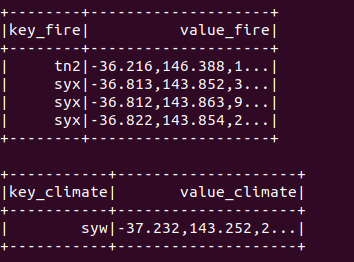

### Step 4: Joining the Stream on the key

In [4]:
joined_df = climate_df.join(fire_df,expr("""key_climate == key_fire"""),"inner")\
            .select("key_climate","key_fire","value_climate","value_fire")

### Step 5 : Write the stream to output sink

In [5]:
# Start running the query that prints the running counts to the console
query = joined_df \
    .writeStream \
    .outputMode("Append")\
    .format("console") \
    .trigger(processingTime='10 seconds') \
    .start()

In the console, you should be able to see the joined output.
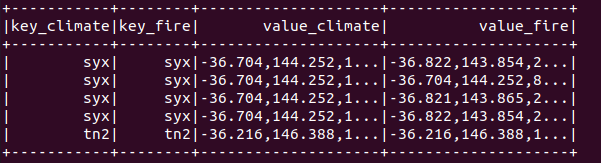

In [6]:
query.stop()

In [7]:
spark.stop()

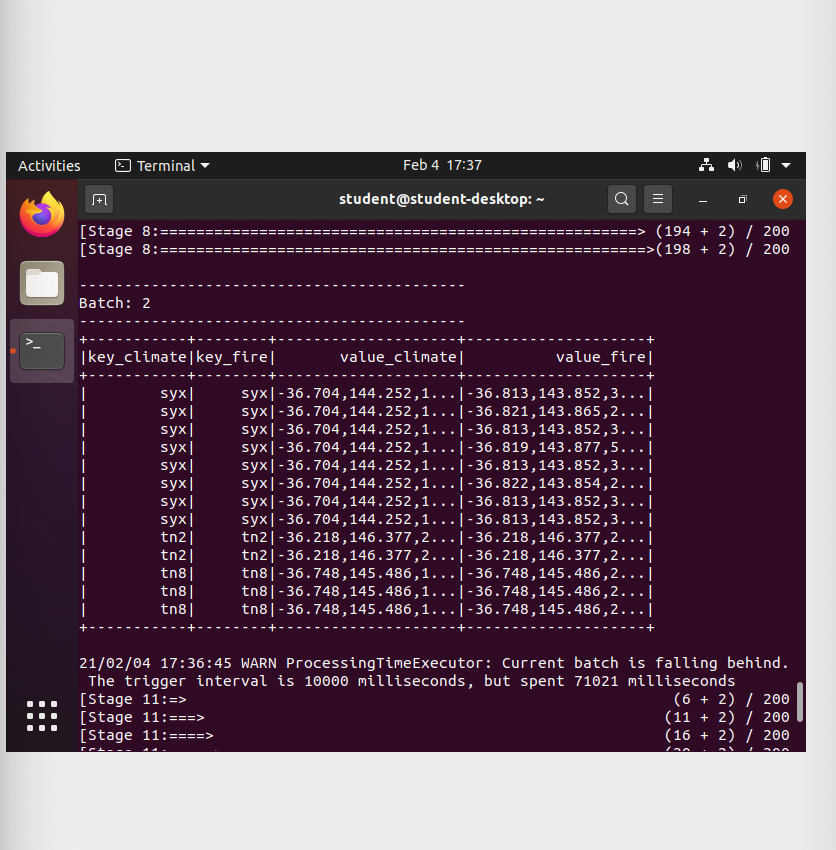